# Project
## Init stuff

In [1]:
import sys
import os
import argparse
import random

import datetime
import time
import copy

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import torch
import torchvision

# we'll use torch for neural networks
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split

# we'll use torchvision for computer vision tasks
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.datasets import CIFAR10
import torchvision.utils as vutils

%matplotlib inline
from matplotlib import pyplot as plt
seed = 42 # deterministic seed
torch.manual_seed(seed)
np.random.seed(seed) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training and inference with device: {device}')

Training and inference with device: cuda


## Gets labels and data

In [2]:
image_path = "images"

labels = [item for item in os.listdir(image_path) if os.path.isdir(os.path.join(image_path,item))]
labels = sorted(labels)
print(labels)
# Gets image data from files

# OLD CODE - NO DATA AUGMENTATION
# Different image_transform because of pretrained model
# image_transform =  Compose([transforms.PILToTensor()])
# image_transform = Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(), 
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# image_data= torchvision.datasets.ImageFolder(image_path, transform=image_transform)

# train_data, eval_data = random_split(image_data, [.7, .3])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.08),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

full_ds = torchvision.datasets.ImageFolder(image_path)   # <- no transform yet

train_len = int(0.70 * len(full_ds))
val_len   = len(full_ds) - train_len
generator = torch.Generator().manual_seed(seed)
train_subset, val_subset = random_split(full_ds, [train_len, val_len], generator=generator)

# attach different transforms to each subset
train_subset.dataset.transform = train_transform
val_subset.dataset.transform   = val_transform

train_data= DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
eval_data= DataLoader(val_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

['backpack', 'book', 'calculator', 'chair', 'clock', 'desk', 'keychain', 'laptop', 'paper', 'pen', 'phone', 'water bottle']


## Display a Batch of Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['phone', 'chair', 'book', 'desk', 'keychain', 'calculator', 'phone', 'book', 'calculator', 'book', 'keychain', 'laptop', 'chair', 'pen', 'water bottle', 'clock', 'backpack', 'backpack', 'paper', 'calculator', 'phone', 'desk', 'clock', 'chair', 'desk', 'pen', 'paper', 'phone', 'desk', 'pen', 'backpack', 'book']


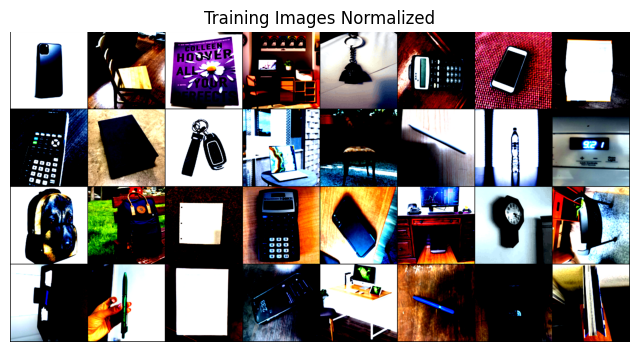

In [3]:
# Displaying the training images normalized that we will use for training 

iterator = iter(train_data)
batch = next(iterator)
image_labels = [ labels[i] for i in batch[-1]]
print(image_labels)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images Normalized")
plt.imshow(np.transpose(vutils.make_grid(batch[0]),(1,2,0)))

['phone', 'chair', 'book', 'desk', 'keychain', 'calculator', 'phone', 'book', 'calculator', 'book', 'keychain', 'laptop', 'chair', 'pen', 'water bottle', 'clock', 'backpack', 'backpack', 'paper', 'calculator', 'phone', 'desk', 'clock', 'chair', 'desk', 'pen', 'paper', 'phone', 'desk', 'pen', 'backpack', 'book']


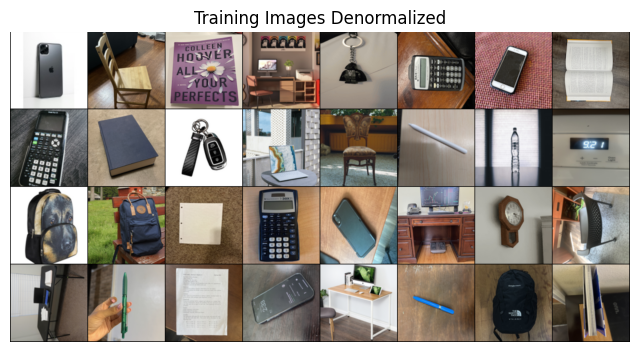

In [4]:
# Displaying the denormalized training images in order to actually visualize the data without over saturation

print(image_labels)
def denormalize_batch(batch_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    batch_tensor = batch_tensor.clone() * std + mean
    return torch.clamp(batch_tensor, 0, 1)

images_denorm = denormalize_batch(batch[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images Denormalized")
plt.imshow(np.transpose(vutils.make_grid(images_denorm, nrow=8), (1, 2, 0)))
plt.show()


## Creating the model

In [5]:
# ResNet18 model version 

def create_resnet18_model(num_classes):
    from torchvision.models import resnet18, ResNet18_Weights

    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights = weights)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    return model, optimizer, loss_func

In [6]:
model, optimizer, loss_func = create_resnet18_model(num_classes = 12)
model = model.to(device)

## Training the model

In [7]:
def train_model(model, train_loader, val_loader, optimizer, loss_func, device, patience, min_delta, lr_step, lr_gamma, epochs = 5):

    scheduler = (torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
                 if lr_step else None)

    best_val_acc = 0.0
    patience_counter = 0  # epochs without improvement

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim = 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_preds = torch.argmax(val_outputs, dim=1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)
        val_acc = val_correct / val_total

        if scheduler:
            scheduler.step()

        # Early Stopping
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered. Restoring best weights.")
                model.load_state_dict(torch.load('best.pt'))
                break

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return model



In [8]:
train_model(model, train_data, eval_data, optimizer, loss_func, device, patience = 8, min_delta = 1e-3, lr_step = 20, lr_gamma = 0.3, epochs = 50)

Epoch 1/50, Loss: 1.3670, Train Acc: 0.6248, Val Acc: 0.8116
Epoch 2/50, Loss: 0.6616, Train Acc: 0.8390, Val Acc: 0.8487
Epoch 3/50, Loss: 0.5413, Train Acc: 0.8591, Val Acc: 0.8669
Epoch 4/50, Loss: 0.4604, Train Acc: 0.8783, Val Acc: 0.8690
Epoch 5/50, Loss: 0.4157, Train Acc: 0.8840, Val Acc: 0.8754
Epoch 6/50, Loss: 0.3789, Train Acc: 0.8976, Val Acc: 0.8859
Epoch 7/50, Loss: 0.3640, Train Acc: 0.9021, Val Acc: 0.8768
Epoch 8/50, Loss: 0.3564, Train Acc: 0.8976, Val Acc: 0.8775
Epoch 9/50, Loss: 0.3379, Train Acc: 0.9099, Val Acc: 0.8789
Epoch 10/50, Loss: 0.3201, Train Acc: 0.9081, Val Acc: 0.8894
Epoch 11/50, Loss: 0.3030, Train Acc: 0.9147, Val Acc: 0.8859
Epoch 12/50, Loss: 0.2961, Train Acc: 0.9132, Val Acc: 0.8810
Epoch 13/50, Loss: 0.2824, Train Acc: 0.9273, Val Acc: 0.8782
Epoch 14/50, Loss: 0.3040, Train Acc: 0.9141, Val Acc: 0.8873
Epoch 15/50, Loss: 0.2825, Train Acc: 0.9168, Val Acc: 0.8880
Epoch 16/50, Loss: 0.2746, Train Acc: 0.9246, Val Acc: 0.8852
Epoch 17/50, Loss

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  